In [1]:
import numpy
data = numpy.loadtxt('/Users/yingzhu/Desktop/train.csv', delimiter=',', skiprows=1)

In [24]:
print(data.shape)
print(data[0].size)

(42000, 785)
785


In [2]:
label=data[:,0]

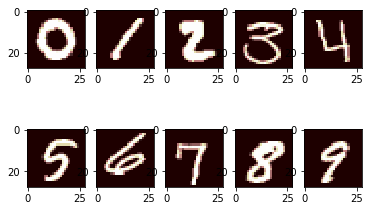

In [5]:
import matplotlib.pyplot as plt
label = data[:,0]
reshape=[]
fig = plt.figure()
for i in range(10):
    for j in range(len(data)):
        if(label[j]==i):
            tar = data[j,:][1:]
            reshape.append(tar.reshape(28,28))
            break;
plt.subplot(251)
plt.imshow(reshape[0], cmap='pink')
plt.subplot(252)
plt.imshow(reshape[1], cmap='pink')
plt.subplot(253)
plt.imshow(reshape[2], cmap='pink')
plt.subplot(254)
plt.imshow(reshape[3], cmap='pink')
plt.subplot(255)
plt.imshow(reshape[4], cmap='pink')
plt.subplot(256)
plt.imshow(reshape[5], cmap='pink')
plt.subplot(257)
plt.imshow(reshape[6], cmap='pink')
plt.subplot(258)
plt.imshow(reshape[7], cmap='pink')
plt.subplot(259)
plt.imshow(reshape[8], cmap='pink')
plt.subplot(2,5,10)
plt.imshow(reshape[9], cmap='pink')
plt.show()

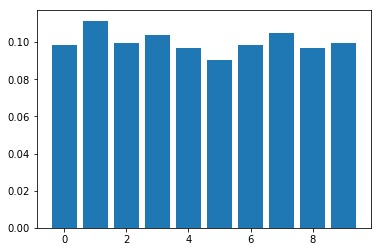

In [6]:
cnt_record=[0]*10
for i in range(10):
    for j in range(len(data)):
        if(label[j]==i):
            cnt_record[i]=cnt_record[i]+1
    cnt_record[i]=cnt_record[i]/len(data)
plt.bar([i for i in range(0,10)],cnt_record)
plt.show()

In [13]:
# try for multi engine parallel computing
from IPython import parallel
rc = parallel.Client()
lv = rc.load_balanced_view()
print (len(lv))

# ipcontroller --profile=default
# ipengine --profile=default
%%px
print("Hello world")

[stdout:0] Hello world
[stdout:1] Hello world


In [8]:
from scipy.spatial.distance import cdist

sample_digit =[]
for i in range(10):
    for j in range(len(data)):
        if(label[j]==i):
            sample_digit.append(j)
            break

In [14]:
def distances_between(i,j):
    temp=data[i,1:]-data[j,1:]
    return (temp*temp).sum()

In [18]:
knn1_index = []
knn1_label=[]
for i in sample_digit:
    min_index = i+1
    min = distances_between(i+1,i)
    for j in range(len(data)):
            if(distances_between(j,i)<min and j!=i):
                min_index= j
                min = distances_between(i,j)
    knn1_index.append(min_index)
    knn1_label.append(label[min_index])

In [19]:
print(knn1_index)
print(knn1_label)

[12950, 29704, 9536, 8981, 14787, 30073, 16240, 15275, 32586, 35742]
[0.0, 1.0, 2.0, 5.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]


In [22]:
## 1(e)
label0=[]
label1=[]
for i in range(len(label)):
    if(label[i]==0):
        label0.append(i)
    if(label[i]==1):
        label1.append(i)
print(len(label0))
print(len(label1))

In [45]:
# decalre label1 and label0 as vector
label_0 = [data[x,1:] for x in label0]
label_1 = [data[x,1:] for x in label1]
label_00_dist= cdist(label_0,label_0)
label_11_dist=cdist(label_1,label_1)
label_10_dist=cdist(label_1,label_0)
print(label_00_dist.shape)
print(label_11_dist.shape)
print(label_10_dist.shape)

4132
4684
(4132, 4132)
(4684, 4684)
(4684, 4132)


In [47]:
label00_dist=list(label_00_dist[numpy.triu_indices(4132)])
print(len(label00_dist))
label11_dist=list(label_11_dist[numpy.triu_indices(4684)])
print(len(label11_dist))

8538778
10972270


In [80]:
label10_dist = numpy.reshape(label_10_dist, (numpy.product(label_10_dist.shape),))
print(len(label10_dist))

19354288


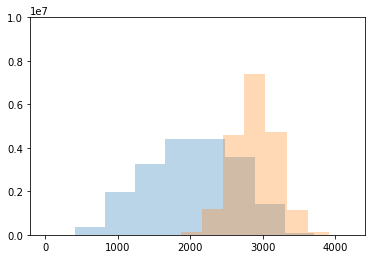

In [81]:
plt.hist(label00_dist+label11_dist,alpha=0.3,bins=10)
plt.hist(label10_dist,alpha=0.3,bins=10)
plt.ylim([0,10000000])
plt.show()

0.8178076851638107 0.19198603430929623


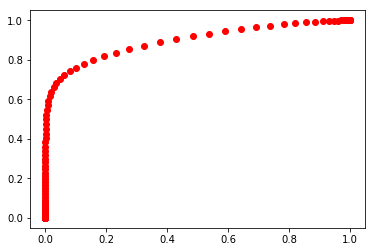

In [410]:
TP = []
FP = []
genuine_dist = label00_dist+label11_dist
impostor_dist = label10_dist
for cutoff in range(200,4000,40):
        tpnew = len([x for x in genuine_dist if x < cutoff])/float(len(genuine_dist))
        fpnew = len([x for x in impostor_dist if x < cutoff])/float(len(impostor_dist))
        if abs(tpnew-(-fpnew+1))<=0.01:
            print(tpnew,fpnew)
        TP.append(tpnew)
        FP.append(fpnew)
plt.plot(FP,TP,'ro')
plt.show()

In [344]:
# 1(g) K-NN classifier
def knn_classifier(x_train,y_train,x_test,k):
    dist = cdist(x_test,x_train)
    sort_index = dist.argsort()[0:len(x_test),0:k]
    y_hat=[]
    for i in range(len(x_test)):
        level_hat=[]
        for j in sort_index[i]:
            level_hat.append(y_train[j])
        ylevel_hat = max(set(level_hat), key=level_hat.count)
        y_hat.append(ylevel_hat)
    return y_hat

In [371]:
#1(h) calculate average accuracy
def accuracy(y_hat,y_test):
    right_result =0
    for i in range(len(y_hat)):
        if(y_hat[i]==y_test[i]):
            right_result+=1;
    return float(right_result/len(y_test))

In [394]:
# 1(h) 3 fold cross_validation on K-NN classifier
from sklearn.cross_validation import KFold
def evaluate(X,Y):
    kf =KFold(len(Y), n_folds=3)
    accu=0.0
    sub_accu_list=[]
    for train_indices, test_indices in kf:
        X_train = X[train_indices]
        Y_train = Y[train_indices]
        X_test = X[test_indices]
        Y_test = Y[test_indices]
        y_hat =knn_classifier(X_train,Y_train,X_test,5)
        subaccu =accuracy(y_hat,Y_test)
        sub_accu_list.append(subaccu)
        accu+=subaccu
    print(sub_accu_list)
    return accu/3.0

In [405]:

res = evaluate(data[:,1:],data[:,0])
print(res)

[0.966, 0.9645714285714285, 0.9660714285714286]
0.965547619047619


In [406]:
# confudion matrix
from sklearn.metrics import confusion_matrix
X= data[:,1:]
Y= data[:,0]
x_train,x_test,y_train,y_test = cross_validation.train_test_split(X,Y)
y_pred=knn_classifier(x_train,y_train,x_test,5)
y_true = y_test
confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

array([[1011,    0,    0,    0,    0,    2,    1,    0,    0,    0],
       [   0, 1160,    3,    0,    0,    0,    1,    2,    0,    1],
       [  11,   13, 1008,    2,    0,    0,    4,   26,    3,    1],
       [   2,    5,    6, 1015,    0,    9,    1,    2,    7,    2],
       [   1,    7,    0,    0,  985,    0,    2,    0,    0,   33],
       [   6,    2,    0,   22,    2,  934,   13,    1,    1,   11],
       [   6,    1,    0,    0,    0,    2, 1027,    0,    1,    0],
       [   0,   10,    4,    0,    2,    0,    0, 1083,    0,    8],
       [   3,   12,    4,   14,    2,   14,    5,    1,  956,   15],
       [   6,    0,    2,    7,   13,    3,    0,    8,    5,  968]])

In [411]:
# train classifer with all of the training data and test classifer with test data
import numpy
test_data = numpy.loadtxt('/Users/yingzhu/Desktop/test.csv', delimiter=',', skiprows=1)

In [415]:
# train the classifer with all of the trainning data
import pandas as pd
y_hat_test = knn_classifier(X,Y,test_data,5)

NameError: name 'y_hat' is not defined

In [418]:
y_hat_res=pd.DataFrame(y_hat_test)
y_hat_res.to_csv('/Users/yingzhu/Desktop/test_res.csv', index=False, header=False)